In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

In [3]:
# Datos
# ==============================================================================
df = pd.read_csv('calidadAireURDECON.csv',";",index_col=0,squeeze=True)
#df = df[["pm25","pm10","co2","humedad","temperatura","presencia"]]# Quito la última columna
#df = df[["pm25","pm10","co2","humedad","temperatura"]]
df = df[["co2","humedad"]]# Solo dejo el CO2 Y la tempeeratura (Mantengo el index de la fecha )
df = df.drop_duplicates(subset=['co2'], keep="last")  # Elimino los duplicados 
df = df.set_index(pd.to_datetime(df.index, format='%d-%m-%Y %H:%M:%S')) # Transformo el index en DateTime
#df = df.asfreq('5min')
#Los registros van de cada 5 minutos. 12 Registros = 1 hora. 48Registros = 4 horas 
df = df[:-48] #Me guardo las últimas 4 horas para la predicción
dfUltimas7Horas = df[-48:]
df.head()

,co2,humedad
fecha,,
2021-10-05 10:39:17,134.77887,41.962310
2021-10-05 10:44:17,139.66228,42.005035
2021-10-05 10:49:17,159.06667,41.980620
2021-10-05 10:54:17,121.99109,42.182040
2021-10-05 10:59:18,116.49886,42.352940


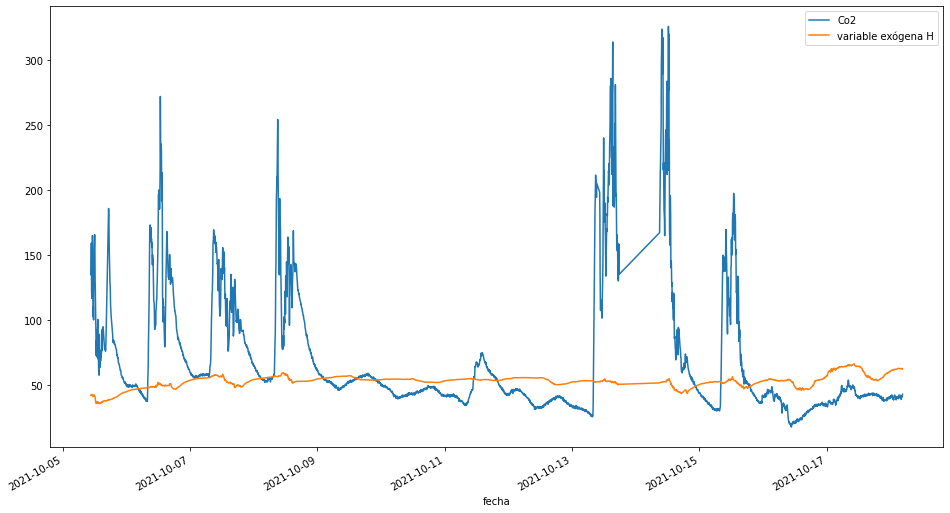

In [4]:
# Preparo datos para el modelo, solo dejo el CO2 y la variable EXÓGENA (Ej:Temperatura) # En un futuro la presencia
# ==============================================================================
#df = df['co2']
# Separo Train y Test
# ==============================================================================
steps = 48
datos_train = df[:-steps]
datos_test  = df[-steps:]

fig, ax = plt.subplots(figsize=(16, 9))
df['co2'].plot(ax=ax, label='Co2')
df['humedad'].plot(ax=ax, label='variable exógena H')
#df['temperatura'].plot(ax=ax, label='variable exógena T')
#df['pm25'].plot(ax=ax, label='variable exógena 25')
#df['pm10'].plot(ax=ax, label='variable exógena 10')
ax.legend();

In [5]:
# Separación datos train-test
# ==============================================================================
steps = 48
datos_train = df[:-steps]
datos_test  = df[-steps:]

# Modelo

In [6]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 10
                )

forecaster_rf.fit(y=datos_train['co2'], exog=datos_train['humedad'])



# Predicción

In [7]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps, exog=datos_test['humedad'])
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)



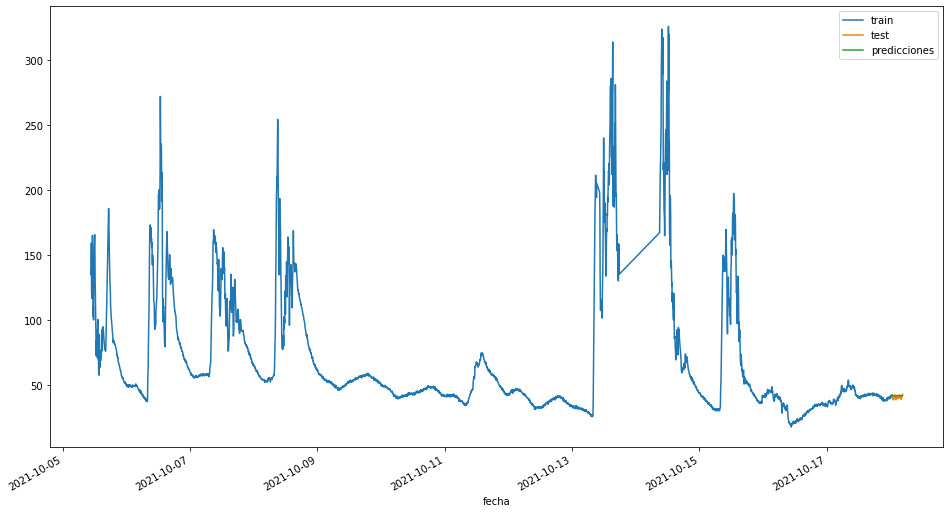

In [8]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(16, 9))
datos_train['co2'].plot(ax=ax, label='train')
datos_test['co2'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [9]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['co2'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 2.534817165253637


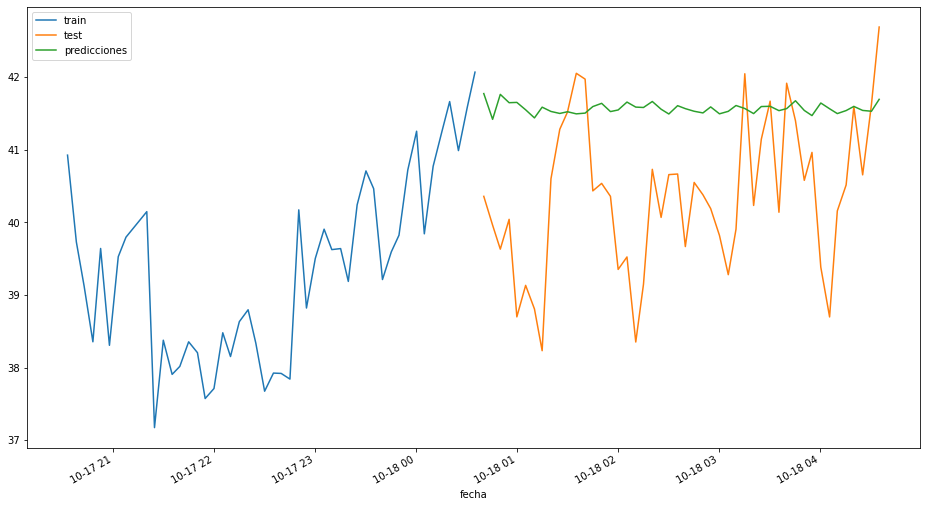

In [19]:
# Dibujo las últimas Horas 
# ==============================================================================
'''plt.plot(range(len(datos_test)),datos_test,c='g')
plt.scatter(range(len(datos_test)),predicciones,c='r')
#plt.scatter(range(len(datos_test)),datos_train,c='b')
plt.legend( ["Test","Prediccion"])
plt.title('as')
plt.show()'''
fig, ax=plt.subplots(figsize=(16, 9))
datos_train['co2'][-steps:].plot(ax=ax, label='train')
datos_test['co2'][-steps:].plot(ax=ax, label='test')
predicciones[-steps:].plot(ax=ax, label='predicciones')
ax.legend();

# Tuning, HiperParametros del modelo 
Para identificar la mejor combinación de lags e hiperparámetros, la librería skforecast dispone de la estrategia de validación cruzada temporal y de backtesting. Independientemente de la estrategia utilizada, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting. A continuación, se utiliza el primer 50% de observaciones de entrenamiento para el entrenamiento inicial y el segundo 50% para la comparación de los modelos.

In [20]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train['co2'],
                        exog        = datos_train['humedad'],
                        param_grid  = param_grid,
                        lags_grid = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-10-18 08:53:54,525 root       INFO  Number of models compared: 27
loop lags_grid: 100%|████████████████████████████████████████████████████████████████| 3/3 [2:18:24<00:00, 2768.28s/it]
2021-10-18 11:12:19,368 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [1 2 3 4 5] 
params: {'max_depth': 10, 'n_estimators': 500}



In [68]:
# Mejores parámetros
# ==============================================================================
dfMejorResultadoEstimacion.values[0][0].max()  # Mejor Lag
dfMejorResultadoEstimacion.values[0][1]["max_depth"] # Mejor Profundidad
dfMejorResultadoEstimacion.values[0][1]["n_estimators"]  # Mejor nº de estimacions


500

In [21]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,max_depth,n_estimators
8,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 500}",360.632700,10,500
7,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 100}",361.155674,10,100
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",369.897446,5,50
6,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 50}",370.879292,10,50
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",375.529810,5,100


# Los mejores resultados se obtienen si se utiliza una ventana temporal de 5 lags y una configuración de random forest {'max_depth': 10, 'n_estimators': 500}.



In [22]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 5
                )

forecaster_rf.fit(y=datos_train['co2'], exog=datos_train['humedad'])

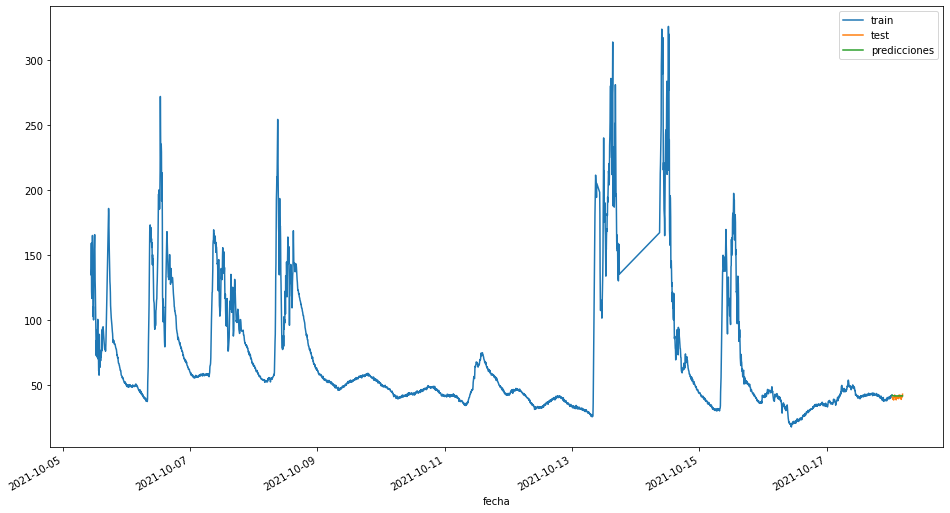

In [23]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps, exog=datos_test['humedad'])
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(16, 9))
datos_train['co2'].plot(ax=ax, label='train')
datos_test['co2'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [24]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['co2'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 2.232157683262544


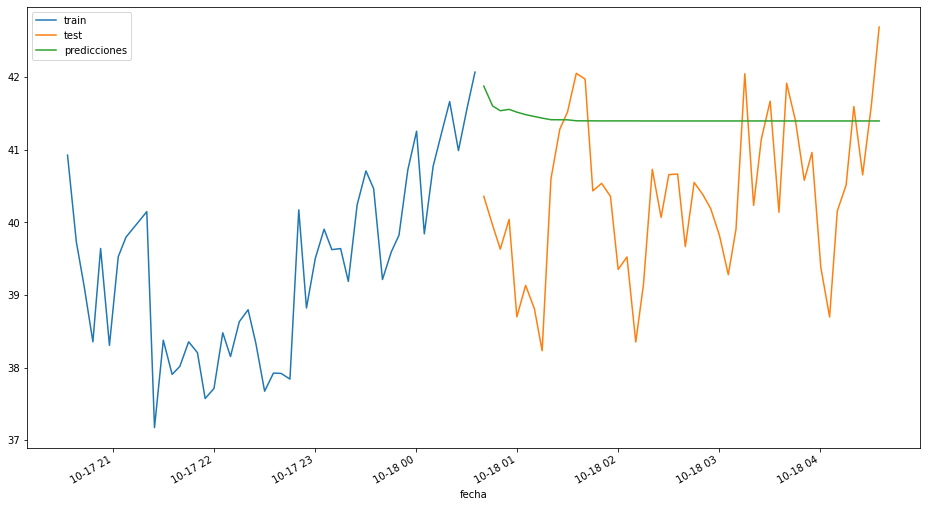

In [25]:
fig, ax=plt.subplots(figsize=(16, 9))
datos_train['co2'][-steps:].plot(ax=ax, label='train')
datos_test['co2'][-steps:].plot(ax=ax, label='test')
predicciones[-steps:].plot(ax=ax, label='predicciones')
ax.legend();